In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split

from going_modular import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

In [2]:
dfs = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/combined_other_datasets_for_modeling.csv')
dfs.columns

print(f"{dfs['Study_id'].value_counts().to_dict()}\n")

print(f"{dfs['Expt'].value_counts().to_dict()}")


{'301': 959, 'miro': 220, 'lica': 176, '302': 168, '216': 155}

{'riluzole': 1282, 'mirocals': 220, 'licals': 176}


In [3]:
miroli = dfs[dfs['Expt'] != 'riluzole']

print(f"{miroli['Study_id'].value_counts().to_dict()}\n")
miroli = miroli.drop(columns=['Study_id'])
print(miroli.info())
miroli.head(3)

{'miro': 220, 'lica': 176}

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        396 non-null    object 
 1   Event             396 non-null    float64
 2   Vital_capacity    396 non-null    float64
 3   Sex               396 non-null    object 
 4   Onset_site        396 non-null    object 
 5   Study_Arm         396 non-null    object 
 6   European          396 non-null    int64  
 7   Age               396 non-null    float64
 8   Diagnostic_Delay  396 non-null    float64
 9   Disease_Duration  396 non-null    float64
 10  TRICALS           396 non-null    float64
 11  Expt              396 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 40.2+ KB
None


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,licals


In [4]:
ril_301 = dfs[dfs['Study_id'] == '301']
ril_301 = ril_301.drop(columns=['Study_id'])

print(f"{ril_301['Expt'].value_counts().to_dict()}\n")
print(ril_301.info())
ril_301.head(3)

{'riluzole': 959}

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 551 to 1509
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        959 non-null    object 
 1   Event             959 non-null    float64
 2   Vital_capacity    959 non-null    float64
 3   Sex               959 non-null    object 
 4   Onset_site        959 non-null    object 
 5   Study_Arm         959 non-null    object 
 6   European          959 non-null    int64  
 7   Age               959 non-null    float64
 8   Diagnostic_Delay  959 non-null    float64
 9   Disease_Duration  959 non-null    float64
 10  TRICALS           959 non-null    float64
 11  Expt              959 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 97.4+ KB
None


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,riluzole
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,riluzole
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,riluzole


In [5]:
proact = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/01_DigitalTwin_2/Processed_Data_2/ALS_Proact_Data_with_tricals_risk_profile.csv')
proact.columns

proact = proact[['subject_id', 'Event', 'vc','Sex', 'Onset_site','Study_Arm', 'European', 'Age','Diag_delay',  'Disease_Duration', 'TRICALS_Risk_Profile']]
proact['Expt'] = 'proact'

proact = proact.rename(columns={'vc': 'Vital_capacity',
                                'Diag_delay': 'Diagnostic_Delay',
                                'TRICALS_Risk_Profile': 'TRICALS'})

print(proact.info())
proact.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        4771 non-null   int64  
 1   Event             4771 non-null   int64  
 2   Vital_capacity    4771 non-null   float64
 3   Sex               4771 non-null   object 
 4   Onset_site        4771 non-null   object 
 5   Study_Arm         4771 non-null   object 
 6   European          4771 non-null   float64
 7   Age               4771 non-null   float64
 8   Diagnostic_Delay  4771 non-null   float64
 9   Disease_Duration  4771 non-null   float64
 10  TRICALS           4771 non-null   float64
 11  Expt              4771 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 447.4+ KB
None


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,121,1,63.037137,Female,limb,Active,1.0,52.00,9.607096,31.849540,-4.184806,proact
1,226,1,56.228941,Male,bulbar,Active,1.0,72.00,10.320302,29.113666,-3.279029,proact
2,624,1,37.825112,Female,limb,Active,1.0,65.14,13.095926,28.748357,-3.282845,proact


In [6]:
miroli.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,licals


In [7]:
ril_301.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,riluzole
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,riluzole
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,riluzole


In [8]:
proact.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt
0,121,1,63.037137,Female,limb,Active,1.0,52.00,9.607096,31.849540,-4.184806,proact
1,226,1,56.228941,Male,bulbar,Active,1.0,72.00,10.320302,29.113666,-3.279029,proact
2,624,1,37.825112,Female,limb,Active,1.0,65.14,13.095926,28.748357,-3.282845,proact


#### check value counts for categorical and object columns

In [9]:
# miroli dataset
check_value_counts(miroli.drop(columns=['subject_id']))

Sex: {'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Onset_site: {'Limb': 318, 'Bulbar': 77, 'Other': 1}

Study_Arm: {'Placebo': 197, 'IL2': 110, 'Active': 89}

Expt: {'mirocals': 220, 'licals': 176}



In [10]:
# riluzole dataset
ril_301 = ril_301[ril_301['Diagnostic_Delay'] >= 0]
check_value_counts(ril_301.drop(columns=['subject_id']))

Sex: {'1': 573, '0': 384}

Onset_site: {'1.0': 913, '2.0': 44}

Study_Arm: {'ACTIVE': 715, 'PLACEBO': 242}

Expt: {'riluzole': 957}



In [11]:
# proact dataset
proact = proact[proact['Onset_site'] != 'other']
proact = proact[proact['Diagnostic_Delay'] >= 0]
check_value_counts(proact.drop(columns=['subject_id']))

Sex: {'Male': 2726, 'Female': 1876}

Onset_site: {'limb': 3565, 'bulbar': 1037}

Study_Arm: {'Active': 3055, 'Placebo': 1547}

Expt: {'proact': 4602}



In [12]:
miroli[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']].describe()
ril_301[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']].describe()
proact[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']].describe()


,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,4602.000000,4602.000000,4602.000000
mean,29.065190,10.931628,66.689094
std,10.582427,5.492224,22.020645
min,4.664915,0.000000,17.632020
25%,21.911958,7.862681,53.482888
50%,27.524474,10.614980,65.740687
75%,33.964602,13.095926,76.124868
max,146.714849,88.961892,252.255771


In [13]:
# Log-transform specified columns
miroli = log_transform_columns(miroli, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
ril_301 = log_transform_columns(ril_301, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
proact = log_transform_columns(proact, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
ril_301.head()

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,riluzole,2.099444,0.206982,4.325708
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,riluzole,3.003325,0.000000,4.856386
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,riluzole,2.956606,0.378382,4.402705
554,11004,0.0,100.882268,0,1.0,ACTIVE,1,65.0,0.000000,19.086728,-2.869897,riluzole,3.000059,0.000000,4.623818
555,11005,1.0,85.222830,1,1.0,ACTIVE,1,52.0,0.000000,17.444152,-3.047773,riluzole,2.914747,0.000000,4.456935


In [14]:
# Make some columns categorical
miroli = make_columns_object(miroli, ['European', 'Event'])
ril_301 = make_columns_object(ril_301, ['European', 'Event'])
proact = make_columns_object(proact, ['European', 'Event'])

# proact.info()
miroli.head(3)
# ril_301.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,licals,3.514542,2.681058,4.682131
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,licals,3.750416,3.051071,4.605170
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,licals,3.571548,2.807691,4.634729


In [15]:
# standardize columns
miroli = standardize_column(miroli)
ril_301 = standardize_column(ril_301)
proact = standardize_column(proact)

ril_301.head()

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,riluzole,2.099444,0.206982,4.325708,-0.721047,0.667003,0.424070,-1.329288,1.193454,-1.002116,0.607142,-0.680409
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,riluzole,3.003325,0.000000,4.856386,2.087427,-1.337433,-0.482680,0.979464,-1.652662,0.757981,-0.530260,1.841255
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,riluzole,2.956606,0.378382,4.402705,-0.399961,0.484782,1.330821,0.802354,0.648189,0.667007,1.549016,-0.314536
554,11004,0.0,100.882268,0,1.0,ACTIVE,1,65.0,0.000000,19.086728,-2.869897,riluzole,3.000059,0.000000,4.623818,0.672229,0.758114,-0.482680,0.966813,-0.136676,0.751622,-0.530260,0.736143
555,11005,1.0,85.222830,1,1.0,ACTIVE,1,52.0,0.000000,17.444152,-3.047773,riluzole,2.914747,0.000000,4.456935,-0.158510,-0.426326,-0.482680,0.650546,-0.400601,0.585497,-0.530260,-0.056847


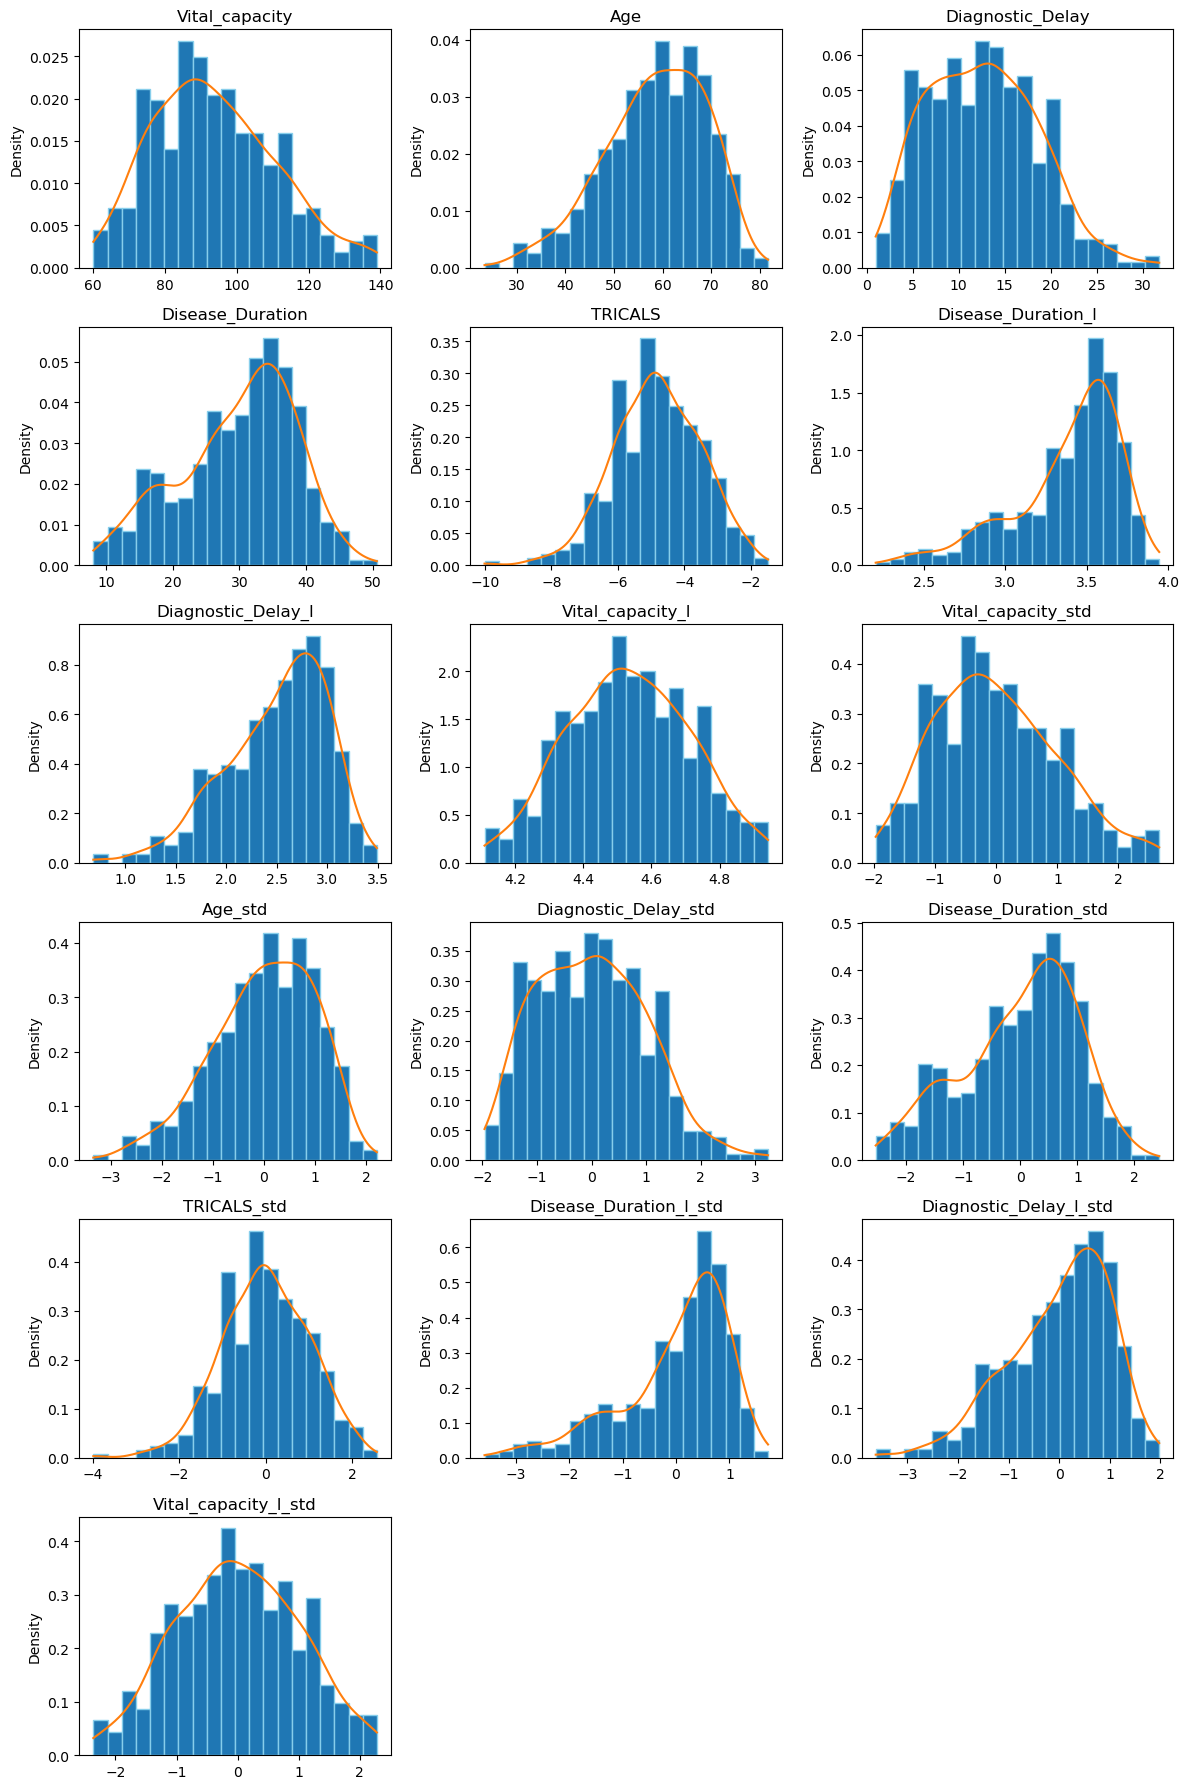

In [16]:
# plot histograms with density
plot_histograms_with_kde(miroli.drop(columns=['subject_id']))

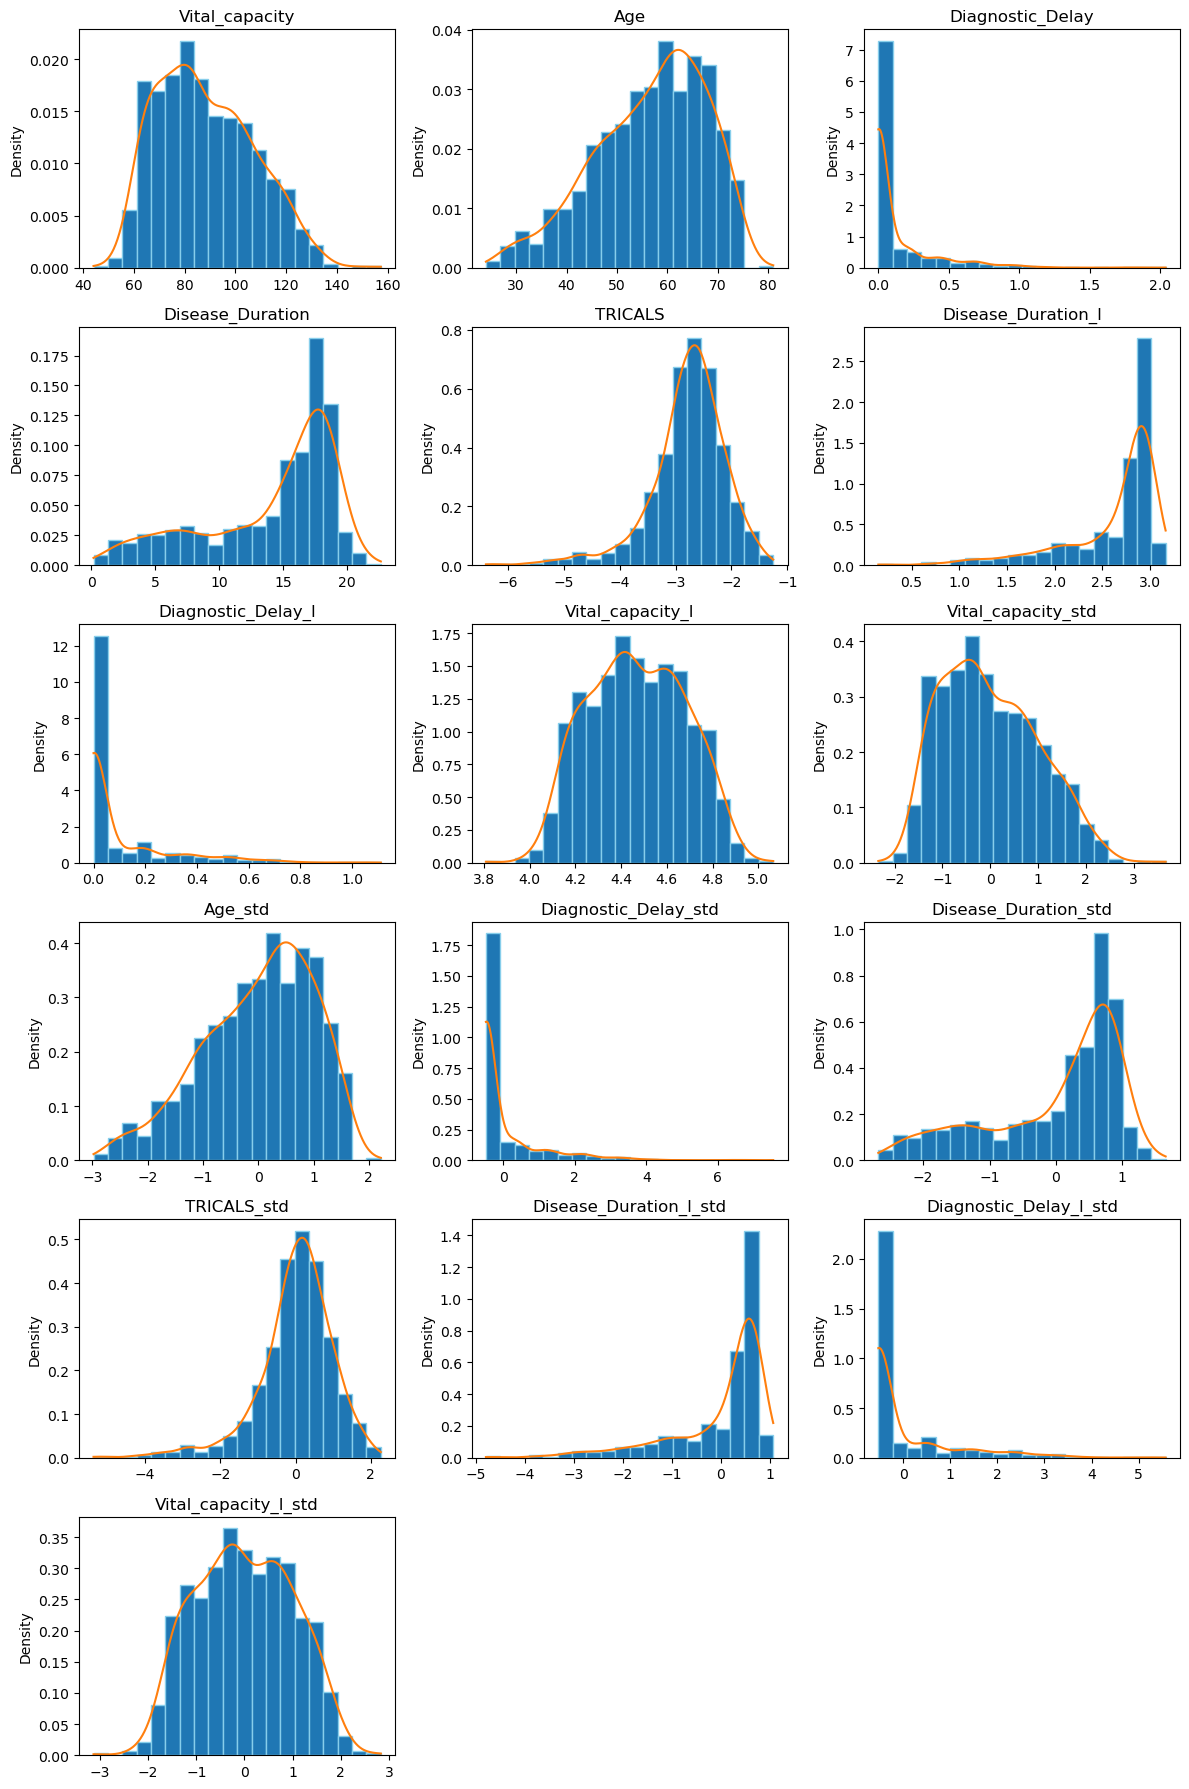

In [17]:
plot_histograms_with_kde(ril_301.drop(columns=['subject_id']))

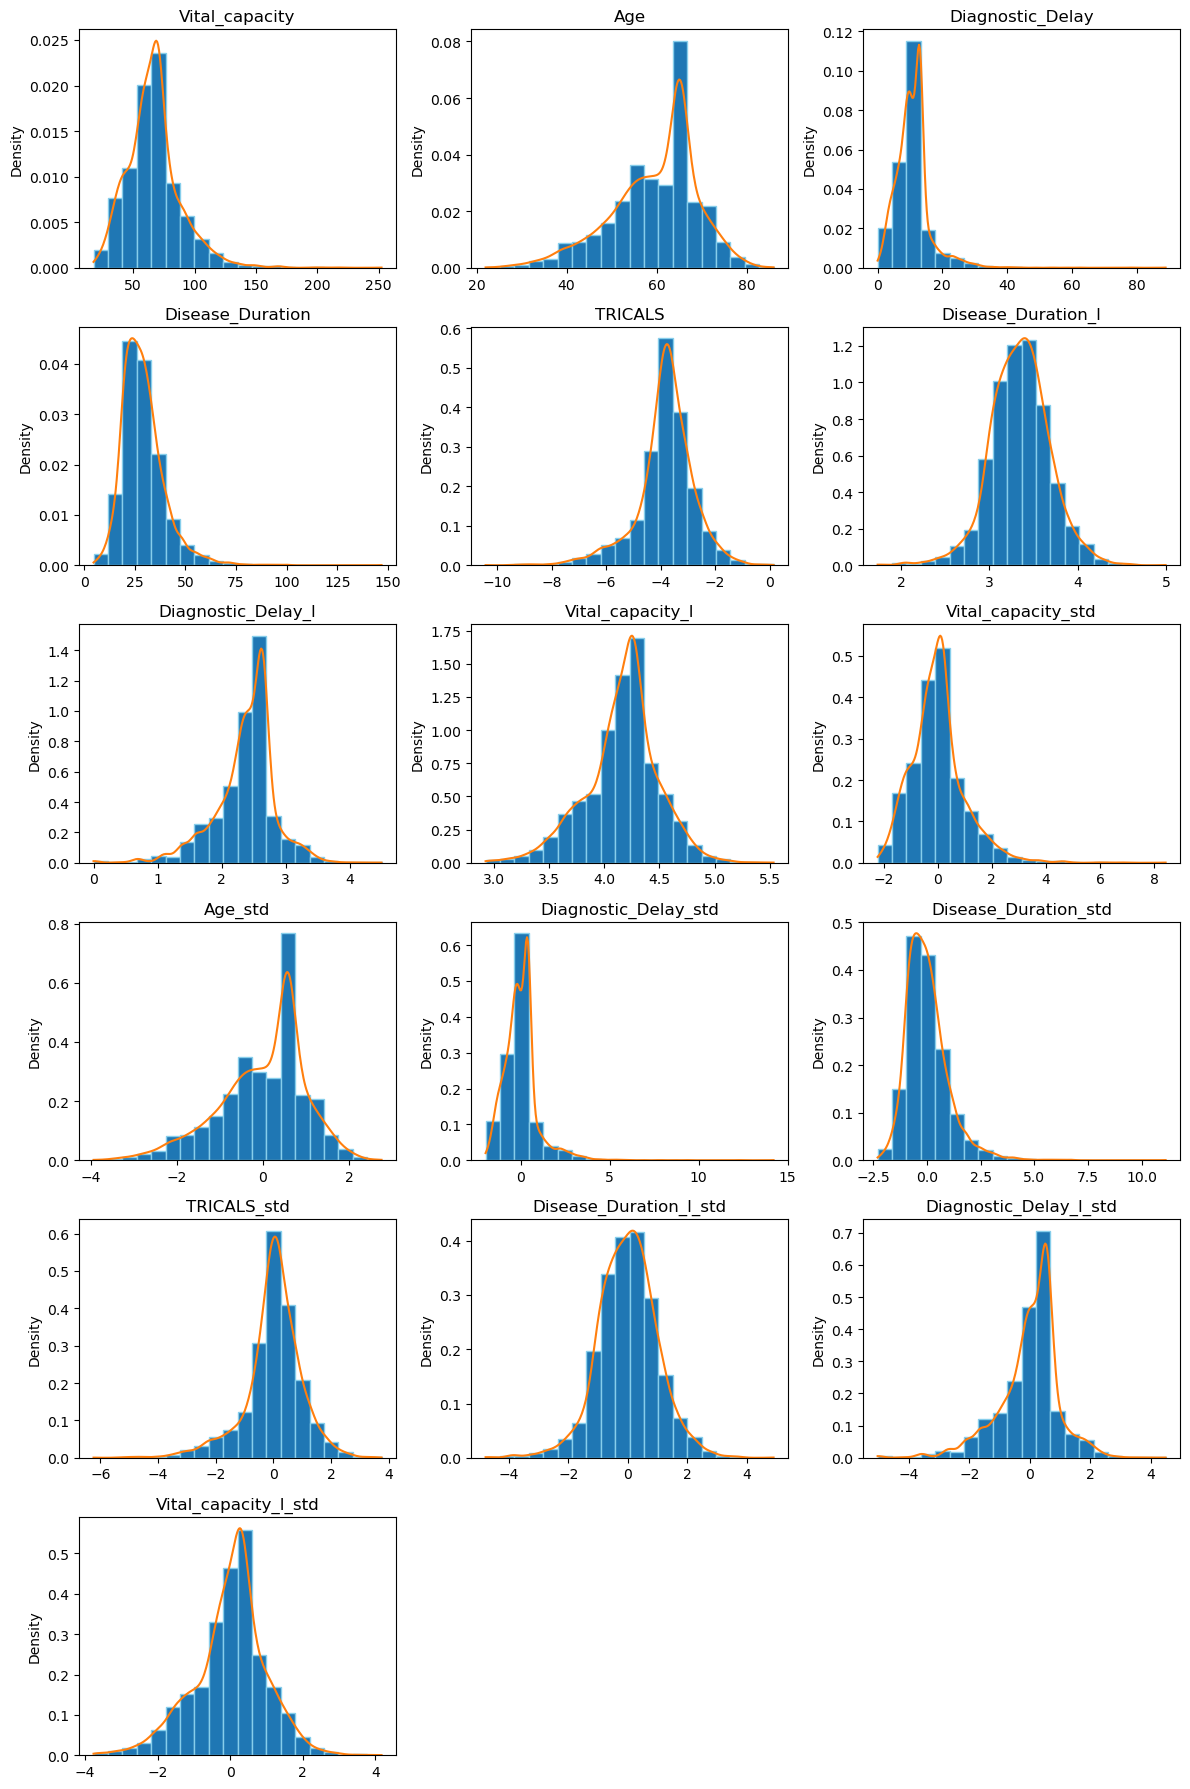

In [18]:
plot_histograms_with_kde(proact.drop(columns=['subject_id']))

In [19]:
check_value_counts(miroli.drop(columns=['subject_id']))


Event: {0.0: 240, 1.0: 156}

Sex: {'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Onset_site: {'Limb': 318, 'Bulbar': 77, 'Other': 1}

Study_Arm: {'Placebo': 197, 'IL2': 110, 'Active': 89}

European: {1: 392, 0: 4}

Expt: {'mirocals': 220, 'licals': 176}



In [20]:
check_value_counts(ril_301.drop(columns=['subject_id']))


Event: {0.0: 531, 1.0: 426}

Sex: {'1': 573, '0': 384}

Onset_site: {'1.0': 913, '2.0': 44}

Study_Arm: {'ACTIVE': 715, 'PLACEBO': 242}

European: {1: 936, 2: 8, 3: 6, 4: 6, 5: 1}

Expt: {'riluzole': 957}



In [21]:
check_value_counts(proact.drop(columns=['subject_id']))

Event: {1: 3366, 0: 1236}

Sex: {'Male': 2726, 'Female': 1876}

Onset_site: {'limb': 3565, 'bulbar': 1037}

Study_Arm: {'Active': 3055, 'Placebo': 1547}

European: {1.0: 4480, 0.0: 122}

Expt: {'proact': 4602}



In [22]:
# miroli dataset
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar',
           'limb': 'Limb', 'bulbar': 'Bulbar',
            'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

miroli['Onset_site'] = miroli['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

miroli['Sex'] = miroli['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

miroli['Study_Arm'] = miroli['Study_Arm'].map(mapping2)

#________
miroli['European'] = np.where(miroli['European'] == 0, 'Non-European', 'European')

In [23]:
# riluzole dataset
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar',
           'limb': 'Limb', 'bulbar': 'Bulbar',
            'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}


ril_301['Onset_site'] = ril_301['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

ril_301['Sex'] = ril_301['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

ril_301['Study_Arm'] = ril_301['Study_Arm'].map(mapping2)

#________
ril_301['European'] = np.where(ril_301['European'] == 0, 'Non-European', 'European')

In [24]:
# proact dataset
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar',
           'limb': 'Limb', 'bulbar': 'Bulbar',
            'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}


proact['Onset_site'] = proact['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

proact['Sex'] = proact['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

proact['Study_Arm'] = proact['Study_Arm'].map(mapping2)

#________
proact['European'] = np.where(proact['European'] == 0, 'Non-European', 'European')

In [25]:
check_value_counts(miroli.drop(columns=['subject_id']))


Event: {0.0: 240, 1.0: 156}

Sex: {'Male': 262, 'Female': 134}

Onset_site: {'Limb': 319, 'Bulbar': 77}

Study_Arm: {'Active': 199, 'Placebo': 197}

European: {'European': 392, 'Non-European': 4}

Expt: {'mirocals': 220, 'licals': 176}



In [26]:
check_value_counts(ril_301.drop(columns=['subject_id']))


Event: {0.0: 531, 1.0: 426}

Sex: {'Male': 573, 'Female': 384}

Onset_site: {'Limb': 913, 'Bulbar': 44}

Study_Arm: {'Active': 715, 'Placebo': 242}

European: {'European': 957}

Expt: {'riluzole': 957}



In [27]:
check_value_counts(proact.drop(columns=['subject_id']))

Event: {1: 3366, 0: 1236}

Sex: {'Male': 2726, 'Female': 1876}

Onset_site: {'Limb': 3565, 'Bulbar': 1037}

Study_Arm: {'Active': 3055, 'Placebo': 1547}

European: {'European': 4480, 'Non-European': 122}

Expt: {'proact': 4602}



In [28]:
proact.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std
0,121,1,63.037137,Female,Limb,Active,European,52.00,9.607096,31.849540,-4.184806,proact,3.491938,2.361523,4.159463,-0.165842,-0.801992,-0.241165,0.263111,-0.343027,0.430658,-0.035771,-0.009882
1,226,1,56.228941,Male,Bulbar,Active,European,72.00,10.320302,29.113666,-3.279029,proact,3.404979,2.426598,4.047060,-0.475016,1.288977,-0.111307,0.004581,0.513738,0.172570,0.102079,-0.351747
2,624,1,37.825112,Female,Limb,Active,European,65.14,13.095926,28.748357,-3.282845,proact,3.392774,2.645886,3.659067,-1.310769,0.571775,0.394066,-0.029939,0.510128,0.136346,0.566605,-1.531791


In [29]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex', 'Study_Arm','Expt']

# One-hot encode
miroli_onehot = pd.get_dummies(miroli, columns=cat_cols, drop_first=True)
ril_301_onehot = pd.get_dummies(ril_301, columns=cat_cols, drop_first=True)
proact_onehot = pd.get_dummies(proact, columns=cat_cols, drop_first=True)

# df_onehot.head(2)

In [30]:
proact_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Disease_Duration_l',
       'Diagnostic_Delay_l', 'Vital_capacity_l', 'Vital_capacity_std',
       'Age_std', 'Diagnostic_Delay_std', 'Disease_Duration_std',
       'TRICALS_std', 'Disease_Duration_l_std', 'Diagnostic_Delay_l_std',
       'Vital_capacity_l_std', 'Onset_site_Limb', 'European_Non-European',
       'Sex_Male', 'Study_Arm_Placebo'],
      dtype='object')

In [31]:
cols = ['Onset_site_Limb', 'Sex_Male', 'Study_Arm_Placebo']

# Convert one-hot encoded columns to int
for col in cols:
    miroli_onehot[col] = miroli_onehot[col].astype(int)

# Convert one-hot encoded columns to int
for col in cols:
    ril_301_onehot[col] = ril_301_onehot[col].astype(int)


# Convert one-hot encoded columns to int
for col in cols:
    proact_onehot[col] = proact_onehot[col].astype(int)

ril_301_onehot.head(3)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,Sex_Male,Study_Arm_Placebo
551,11001,1.0,74.619023,64.0,0.229961,7.161629,-1.973438,2.099444,0.206982,4.325708,-0.721047,0.667003,0.424070,-1.329288,1.193454,-1.002116,0.607142,-0.680409,1,1,0
552,11002,0.0,127.558757,42.0,0.000000,19.152431,-3.891616,3.003325,0.000000,4.856386,2.087427,-1.337433,-0.482680,0.979464,-1.652662,0.757981,-0.530260,1.841255,1,1,1
553,11003,1.0,80.671485,62.0,0.459921,18.232589,-2.340926,2.956606,0.378382,4.402705,-0.399961,0.484782,1.330821,0.802354,0.648189,0.667007,1.549016,-0.314536,1,1,0


In [32]:
# Create interactions
miroli_onehot['Sex_onset'] = miroli_onehot['Sex_Male']*miroli_onehot['Onset_site_Limb']
miroli_onehot['Age_Sex'] = miroli_onehot['Sex_Male']*miroli_onehot['Age_std']
miroli_onehot['Age_onset'] = miroli_onehot['Age_std']*miroli_onehot['Onset_site_Limb']
miroli_onehot['Age_TRICALS'] = miroli_onehot['Age_std']*miroli_onehot['TRICALS_std']
# miroli_onehot['Trical : Placebo Arm'] = miroli_onehot['TRICALS']*miroli_onehot['Study_Arm_Placebo']

# miroli_onehot.info()
miroli_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441,1,False,1,1,False,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812,1,False,0,1,False,0,0.000000,0.255274,-0.298299


In [33]:
# Create interactions
ril_301_onehot['Sex_onset'] = ril_301_onehot['Sex_Male']*ril_301_onehot['Onset_site_Limb']
ril_301_onehot['Age_Sex'] = ril_301_onehot['Sex_Male']*ril_301_onehot['Age_std']
ril_301_onehot['Age_onset'] = ril_301_onehot['Age_std']*ril_301_onehot['Onset_site_Limb']
ril_301_onehot['Age_TRICALS'] = ril_301_onehot['Age_std']*ril_301_onehot['TRICALS_std']
# ril_301_onehot['Trical : Placebo Arm'] = ril_301_onehot['TRICALS']*ril_301_onehot['Study_Arm_Placebo']

# ril_301_onehot.info()
ril_301_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,Sex_Male,Study_Arm_Placebo,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
551,11001,1.0,74.619023,64.0,0.229961,7.161629,-1.973438,2.099444,0.206982,4.325708,-0.721047,0.667003,0.42407,-1.329288,1.193454,-1.002116,0.607142,-0.680409,1,1,0,1,0.667003,0.667003,0.796037
552,11002,0.0,127.558757,42.0,0.000000,19.152431,-3.891616,3.003325,0.000000,4.856386,2.087427,-1.337433,-0.48268,0.979464,-1.652662,0.757981,-0.530260,1.841255,1,1,1,1,-1.337433,-1.337433,2.210326


In [34]:
# Create interactions
proact_onehot['Sex_onset'] = proact_onehot['Sex_Male']*proact_onehot['Onset_site_Limb']
proact_onehot['Age_Sex'] = proact_onehot['Sex_Male']*proact_onehot['Age_std']
proact_onehot['Age_onset'] = proact_onehot['Age_std']*proact_onehot['Onset_site_Limb']
proact_onehot['Age_TRICALS'] = proact_onehot['Age_std']*proact_onehot['TRICALS_std']
# proact_onehot['Trical : Placebo Arm'] = proact_onehot['TRICALS']*proact_onehot['Study_Arm_Placebo']

# miroli_onehot.info()
proact_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,121,1,63.037137,52.0,9.607096,31.849540,-4.184806,3.491938,2.361523,4.159463,-0.165842,-0.801992,-0.241165,0.263111,-0.343027,0.430658,-0.035771,-0.009882,1,False,0,0,0,-0.000000,-0.801992,0.275105
1,226,1,56.228941,72.0,10.320302,29.113666,-3.279029,3.404979,2.426598,4.047060,-0.475016,1.288977,-0.111307,0.004581,0.513738,0.172570,0.102079,-0.351747,0,False,1,0,0,1.288977,0.000000,0.662197


In [35]:
miroli0 = miroli_onehot.copy()
ril_3010 = ril_301_onehot.copy()
proact0 = proact_onehot.copy()


In [36]:
proact0.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Disease_Duration_l',
       'Diagnostic_Delay_l', 'Vital_capacity_l', 'Vital_capacity_std',
       'Age_std', 'Diagnostic_Delay_std', 'Disease_Duration_std',
       'TRICALS_std', 'Disease_Duration_l_std', 'Diagnostic_Delay_l_std',
       'Vital_capacity_l_std', 'Onset_site_Limb', 'European_Non-European',
       'Sex_Male', 'Study_Arm_Placebo', 'Sex_onset', 'Age_Sex', 'Age_onset',
       'Age_TRICALS'],
      dtype='object')

In [37]:
miroli0 = miroli0[['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male','Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

miroli0 = miroli0.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

miroli0.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [38]:
ril_3010 = ril_3010[['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male','Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

ril_3010 = ril_3010.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

ril_3010.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [39]:
proact0 = proact0[['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male','Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

proact0 = proact0.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

proact0.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [40]:
# df1.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/processed_data_for_flexible_parametric_model.csv', index=False)

In [41]:
miroli0.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,32.600526,1,-0.355001,-0.075830,0.363265,0.828441,1,1,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,41.538765,1,0.255274,-1.168542,1.103061,0.398812,1,0,0,0.000000,0.255274,-0.298299
2,P01003,0.0,34.571616,0,-1.123785,-1.189109,0.616453,0.563821,1,1,1,-1.123785,-1.123785,1.336303


In [42]:
ril_3010.head()

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
551,11001,1.0,7.161629,0,0.667003,1.193454,0.607142,-0.680409,1,1,1,0.667003,0.667003,0.796037
552,11002,0.0,19.152431,1,-1.337433,-1.652662,-0.530260,1.841255,1,1,1,-1.337433,-1.337433,2.210326
553,11003,1.0,18.232589,0,0.484782,0.648189,1.549016,-0.314536,1,1,1,0.484782,0.484782,0.314230
554,11004,0.0,19.086728,0,0.758114,-0.136676,-0.530260,0.736143,1,0,0,0.000000,0.758114,-0.103616
555,11005,1.0,17.444152,0,-0.426326,-0.400601,-0.530260,-0.056847,1,1,1,-0.426326,-0.426326,0.170787


In [43]:
ril_301.Age_std.mean()

np.float64(2.487270809609546e-16)

In [44]:
miroli0 = make_columns_int(miroli0, ["Event"])
ril_3010 = make_columns_int(ril_3010, ["Event"])
proact0 = make_columns_int(proact0, ["Event"])

/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/going_modular/make_columns_int.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0).astype(int)
/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/going_modular/make_columns_int.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0).astype(int)
/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/going_modular/make_columns_int.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will cha

In [45]:
# Train / Test split
print(miroli0.shape)

# Separate features from survival info
X = miroli0.drop(columns=['Disease_Duration', 'Event'])
y_duration = miroli0['Disease_Duration']
y_event = miroli0['Event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.25, random_state=4
)

# Combine back for lifelines format
train_df = X_train.copy()
train_df['Disease_Duration'] = y_duration_train
train_df['Event'] = y_event_train

test_df = X_test.copy()
test_df['Disease_Duration'] = y_duration_test
test_df['Event'] = y_event_test

len(train_df), len(test_df)

(396, 14)


(297, 99)

In [46]:
with conversion.localconverter(pandas2ri.converter):
    r_miroli0 = pandas2ri.py2rpy(miroli0)

with conversion.localconverter(pandas2ri.converter):
    r_train_df = pandas2ri.py2rpy(train_df)

with conversion.localconverter(pandas2ri.converter):
    r_test_df = pandas2ri.py2rpy(test_df)

with conversion.localconverter(pandas2ri.converter):
    r_ril_3010 = pandas2ri.py2rpy(ril_3010)

with conversion.localconverter(pandas2ri.converter):
    r_proact0 = pandas2ri.py2rpy(proact0)

#### CV Backward stepwise selection based on AIC and spline df selection
<!-- ##### investigate the code further -->

In [47]:
# Candidate covariates (modify for your dataset)
covariates = [
   'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay', 'Study_Arm_Placebo',
       'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS'
    ]

df_candidates = [0, 1, 2, 3, 4, 5]

In [48]:
# import inspect
# inspect.signature(perform_fp_model_cv_aic_for_model)


In [49]:
# Perform flexible parametric model cross-validation with AIC
# model_0 = perform_fp_model_cv_aic_for_model(train_df=train_df, covariates=covariates, df_candidates=df_candidates, n_splits=5)
# model_0

### *Fit a flexible parametric survival model (baseline model) -  The baseline log-cumulative-hazard* 

In [50]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age + TRICALS + Diagnostic_Delay + Onset_Limb + Sex_Male + Sex_onset')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_miroli0, df=0)
# print(ro.r.summary(fp_model))

In [51]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb + TRICALS + Diagnostic_Delay + Study_Arm_Placebo')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_train_df, df=0)
# print(ro.r.summary(fp_model))

In [52]:
df_coef = extract_coefficients_from_fp_model_log_haz_scale(fp_model)
df_coef = round(df_coef, 4)
df_coef

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),LHR,CI_lower,CI_upper,Significant
0,Age,-0.4528,0.1279,-3.5389,0.0004,-0.4528,-0.7035,-0.2020,True
1,Sex_Male,-0.0117,0.1950,-0.0600,0.9522,-0.0117,-0.3938,0.3704,False
2,Onset_Limb,0.3919,0.2314,1.6933,0.0904,0.3919,-0.0617,0.8455,False
3,TRICALS,3.1346,0.2303,13.6109,0.0000,3.1346,2.6832,3.5860,True
4,Diagnostic_Delay,0.2576,0.1136,2.2666,0.0234,0.2576,0.0348,0.4803,True
5,Study_Arm_Placebo,0.2099,0.1841,1.1405,0.2541,0.2099,-0.1508,0.5706,False


In [53]:
df_coef = extract_coefficients_from_fp_model_haz_scale(fp_model)
df_coef = round(df_coef, 4)
df_coef

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.4528,0.1279,-3.5389,0.0004,0.6359,0.4948,0.8171,True
1,Sex_Male,-0.0117,0.1950,-0.0600,0.9522,0.9884,0.6745,1.4484,False
2,Onset_Limb,0.3919,0.2314,1.6933,0.0904,1.4798,0.9402,2.3291,False
3,TRICALS,3.1346,0.2303,13.6109,0.0000,22.9799,14.6322,36.0898,True
4,Diagnostic_Delay,0.2576,0.1136,2.2666,0.0234,1.2938,1.0355,1.6165,True
5,Study_Arm_Placebo,0.2099,0.1841,1.1405,0.2541,1.2336,0.8600,1.7694,False


Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



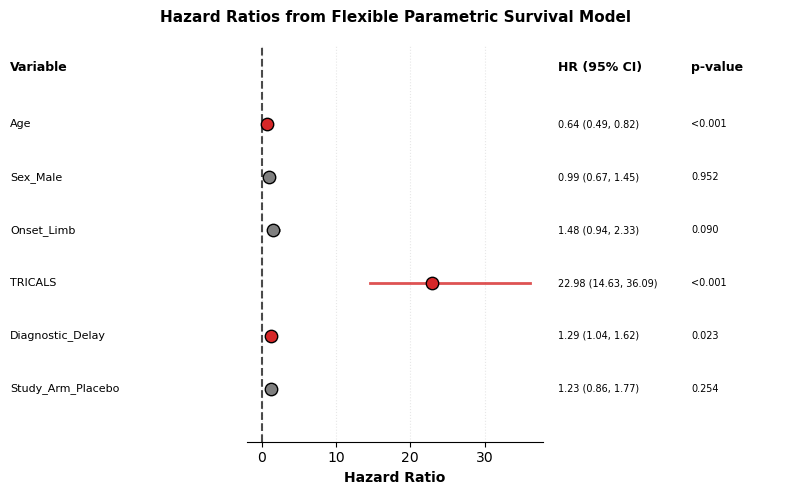

In [54]:
forest_plot_fp_model_haz_scale(extract_coefficients_from_fp_model_haz_scale(fp_model))

In [55]:
# train_df.columns = train_df.columns.str.replace(' ', '_')
# test_df.columns = test_df.columns.str.replace(' ', '_')
ril_3010.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [56]:
means = ["Age", "TRICALS", "Diagnostic_Delay"]
modes = ["Sex_Male", "Onset_Limb", "Sex_onset",'Study_Arm_Placebo']

In [57]:
# Prepare newdata for train and test
times_train = np.linspace(0, train_df["Disease_Duration"].max(), 100)
newdata_train = make_newdata_for_fp_model_prediction(train_df, times_train, means, modes, 'Disease_Duration')

times_test = np.linspace(0, test_df["Disease_Duration"].max(), 100)
newdata_test = make_newdata_for_fp_model_prediction(test_df, times_test, means, modes, 'Disease_Duration')

times_miroli0 = np.linspace(0, miroli0["Disease_Duration"].max(), 100)
newdata_miroli0 = make_newdata_for_fp_model_prediction(miroli0, times_miroli0, means, modes, 'Disease_Duration')

times_ril_3010 = np.linspace(0, ril_3010["Disease_Duration"].max(), 100)
newdata_ril_3010 = make_newdata_for_fp_model_prediction(ril_3010, times_ril_3010, means, modes, 'Disease_Duration')

times_proact0 = np.linspace(0, proact0["Disease_Duration"].max(), 100)
newdata_proact0 = make_newdata_for_fp_model_prediction(proact0, times_proact0, means, modes, 'Disease_Duration')

So while you can generate predictions at 50 months, you cannot validate them.

Prediction may be possible. Validation is not.


If you pretend the second trial has 50 months of follow-up:

You create informative censoring

You inflate uncertainty

You risk misleading conclusions about long-term survival

You can say:

“The model was trained on a 50-month trial and externally validated on an independent 22-month trial. Model performance was assessed at clinically relevant time points up to 22 months.”

In [58]:
# ril_3010['Disease_Duration'].describe()
# miroli0['Disease_Duration'].describe()
# proact0['Disease_Duration'].describe()

In [59]:
newdata_miroli0
newdata_ril_3010
# newdata_train

Age,TRICALS,Diagnostic_Delay,...,Sex_onset,Study_Arm_Placebo,Disease_Duration
0.000000,0.000000,0.000000,...,1,0,0.000000
0.000000,0.000000,0.000000,,1,0,0.228965
0.000000,0.000000,0.000000,,1,0,0.457930
0.000000,0.000000,0.000000,,1,0,0.686895
...,...,...,,...,...,...
0.000000,0.000000,0.000000,,1,0,21.980647
0.000000,0.000000,0.000000,,1,0,22.209613
0.000000,0.000000,0.000000,,1,0,22.438578
0.000000,0.000000,0.000000,,1,0,22.667543


In [60]:
# import inspect
# inspect.signature(prediction_survival_for_average_patient_fp_model_train_test)

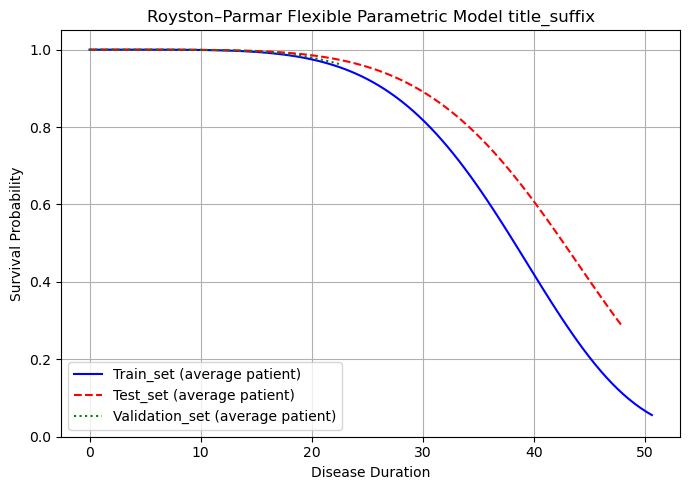

In [61]:
prediction_survival_for_average_patient_fp_model_train_test(train_df,
                                                            test_df,
                                                            ril_3010,
                                                            fp_model,
                                                            newdata_train=newdata_train,
                                                            newdata_test=newdata_test,
                                                            newdata_valid=newdata_ril_3010,
                                                            time_col='Disease_Duration',
                                                            title_suffix="title_suffix",
                                                            Train_set='Train_set',
                                                            Test_set='Test_set',
                                                            Validation_set='Validation_set')

In [62]:
newdata_0_train, newdata_1_train = make_newdata_category_for_fp_model_prediction(train_df, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')
newdata_0_test, newdata_1_test = make_newdata_category_for_fp_model_prediction(test_df, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')
newdata_0_valid, newdata_1_valid = make_newdata_category_for_fp_model_prediction(ril_3010, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')

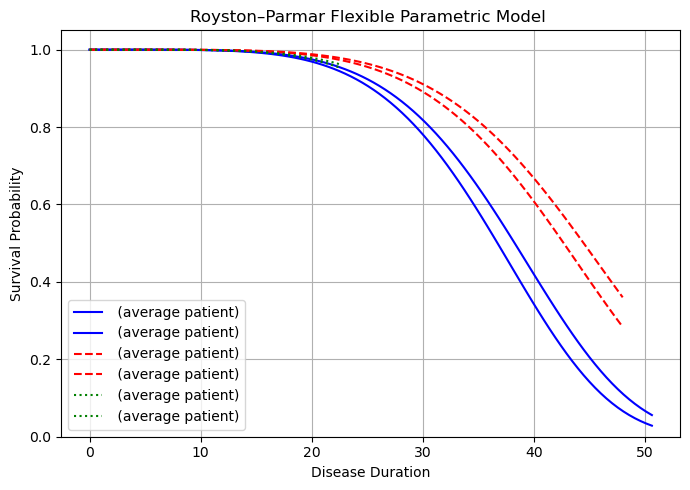

In [63]:
prediction_survival_for_average_patient_cat_cov_fp_model_train_test(df_train=train_df,
                                                                    df_test=test_df,
                                                                    df_valid=ril_3010,
                                                                    fp_model=fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    newdata_0_valid=newdata_0_valid,
                                                                    newdata_1_valid=newdata_1_valid,
                                                                    time_col="Disease_Duration",
                                                                    title_suffix="",
                                                                    Train_set="",
                                                                    Test_set="",
                                                                    Validation_set=""
                                                                )

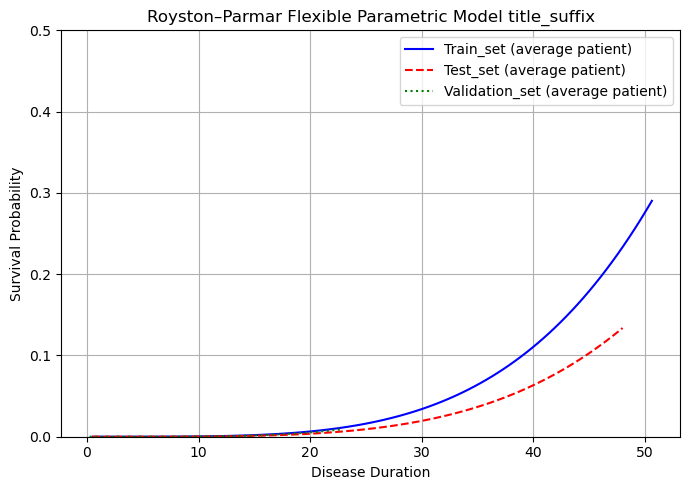

In [64]:
prediction_hazard_for_average_patient_fp_model_train_test(
    train_df,
    test_df,
    ril_3010,
    fp_model,
    newdata_train=newdata_train,
    newdata_test=newdata_test,
    newdata_valid=newdata_ril_3010,
    time_col='Disease_Duration',
    title_suffix="title_suffix",
    Train_set='Train_set',
    Test_set='Test_set',
    Validation_set='Validation_set')

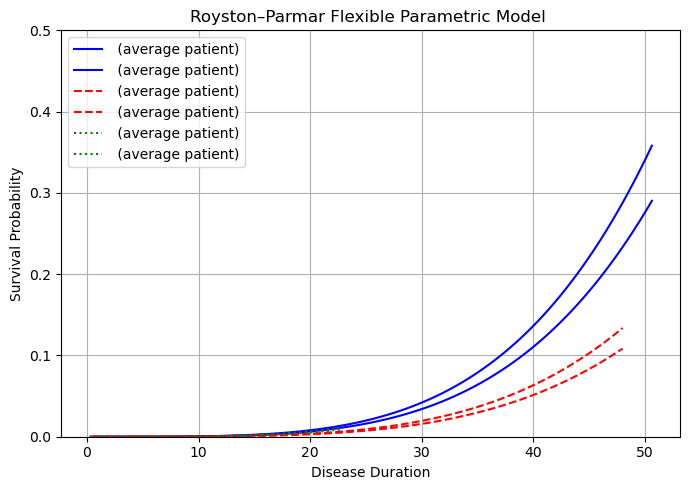

In [66]:
prediction_hazard_for_average_patient_cat_cov_fp_model_train_test(df_train=train_df,
                                                                    df_test=test_df,
                                                                    df_valid=ril_3010,
                                                                    fp_model=fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    newdata_0_valid=newdata_0_valid,
                                                                    newdata_1_valid=newdata_1_valid,
                                                                    time_col="Disease_Duration",
                                                                    title_suffix="",
                                                                    Train_set="",
                                                                    Test_set="",
                                                                    Validation_set=""
                                                                )

## Prognostic Scores for Baseline Model (fit)

In [68]:
train_df = prognostic_score(train_df, fp_model, groups=3)
train_df.head(3)

,subject_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Disease_Duration,Event,prognostic_score,risk_group
274,1-62532,1,0.545148,-0.904108,1.264189,-1.207151,1,0,0,0.000000,0.545148,-0.492873,44.052967,0,-2.376219,Low
291,1-63842,0,0.157333,-0.587463,-0.514605,-1.435037,1,1,1,0.157333,0.157333,-0.092428,30.324967,0,-3.791205,Low
103,P06011,0,-0.164894,-0.196964,0.779864,0.563821,1,0,0,-0.000000,-0.164894,0.032478,32.207622,1,-1.769135,Medium


In [69]:
train_df['risk_group'] = pd.qcut(train_df['prognostic_score'], 3, labels=['Low','Medium','High'])

train_df.head(6)
train_df.risk_group.value_counts().to_dict()

{'Low': 99, 'Medium': 99, 'High': 99}

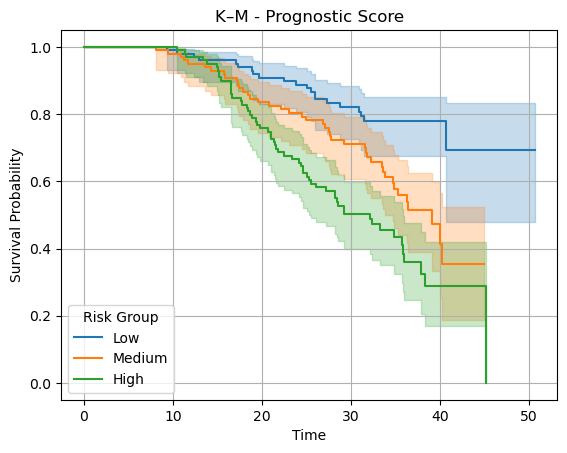

In [70]:
for group in ['Low','Medium','High']:
    subset = train_df[train_df['risk_group']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

## ***Simulate Virtual Placebo***

In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 274 to 122
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   subject_id         297 non-null    object  
 1   Study_Arm_Placebo  297 non-null    int64   
 2   Age                297 non-null    float64 
 3   TRICALS            297 non-null    float64 
 4   Diagnostic_Delay   297 non-null    float64 
 5   Vital_capacity     297 non-null    float64 
 6   Onset_Limb         297 non-null    int64   
 7   Sex_Male           297 non-null    int64   
 8   Sex_onset          297 non-null    int64   
 9   Age_Sex            297 non-null    float64 
 10  Age_onset          297 non-null    float64 
 11  Age_TRICALS        297 non-null    float64 
 12  Disease_Duration   297 non-null    float64 
 13  Event              297 non-null    int64   
 14  prognostic_score   297 non-null    float64 
 15  risk_group         297 non-null    category
dtypes: category

In [72]:
cols = ['subject_id']

for col in (train_df.select_dtypes(include=['object', 'category', 'int']).columns):
    if col not in cols:
        print(f"{train_df[col].value_counts() / train_df[col].value_counts().sum()}\n")

Study_Arm_Placebo
0    0.505051
1    0.494949
Name: count, dtype: float64

Onset_Limb
1    0.804714
0    0.195286
Name: count, dtype: float64

Sex_Male
1    0.649832
0    0.350168
Name: count, dtype: float64

Sex_onset
1    0.555556
0    0.444444
Name: count, dtype: float64

Event
0    0.592593
1    0.407407
Name: count, dtype: float64

risk_group
Low       0.333333
Medium    0.333333
High      0.333333
Name: count, dtype: float64



In [74]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
pla = train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()
# exp = train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()
# eur = train_df['European_Yes'].value_counts() / train_df['European_Yes'].value_counts().sum()


In [75]:
ons, sex

(Onset_Limb
 1    0.804714
 0    0.195286
 Name: count, dtype: float64,
 Sex_Male
 1    0.649832
 0    0.350168
 Name: count, dtype: float64)

In [78]:
train_df.head(3)

,subject_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Disease_Duration,Event,prognostic_score,risk_group
274,1-62532,1,0.545148,-0.904108,1.264189,-1.207151,1,0,0,0.000000,0.545148,-0.492873,44.052967,0,-2.376219,Low
291,1-63842,0,0.157333,-0.587463,-0.514605,-1.435037,1,1,1,0.157333,0.157333,-0.092428,30.324967,0,-3.791205,Low
103,P06011,0,-0.164894,-0.196964,0.779864,0.563821,1,0,0,-0.000000,-0.164894,0.032478,32.207622,1,-1.769135,Medium


In [79]:
train_df.columns

Index(['subject_id', 'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset', 'Age_Sex',
       'Age_onset', 'Age_TRICALS', 'Disease_Duration', 'Event',
       'prognostic_score', 'risk_group'],
      dtype='object')

In [80]:
train_df.head(3)

,subject_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Disease_Duration,Event,prognostic_score,risk_group
274,1-62532,1,0.545148,-0.904108,1.264189,-1.207151,1,0,0,0.000000,0.545148,-0.492873,44.052967,0,-2.376219,Low
291,1-63842,0,0.157333,-0.587463,-0.514605,-1.435037,1,1,1,0.157333,0.157333,-0.092428,30.324967,0,-3.791205,Low
103,P06011,0,-0.164894,-0.196964,0.779864,0.563821,1,0,0,-0.000000,-0.164894,0.032478,32.207622,1,-1.769135,Medium


In [82]:
corr = train_df[['Age','Study_Arm_Placebo','Diagnostic_Delay','Vital_capacity','Sex_Male', 
            	 'Onset_Limb','TRICALS']].corr()
corr

,Age,Study_Arm_Placebo,Diagnostic_Delay,Vital_capacity,Sex_Male,Onset_Limb,TRICALS
Age,1.000000,0.046516,0.087078,0.076591,-0.103332,-0.031105,0.380008
Study_Arm_Placebo,0.046516,1.000000,0.120369,0.053106,-0.021533,0.045987,-0.048690
Diagnostic_Delay,0.087078,0.120369,1.000000,-0.022584,-0.001519,-0.020859,-0.437893
Vital_capacity,0.076591,0.053106,-0.022584,1.000000,-0.156111,0.100883,-0.224200
Sex_Male,-0.103332,-0.021533,-0.001519,-0.156111,1.000000,0.172537,-0.104451
Onset_Limb,-0.031105,0.045987,-0.020859,0.100883,0.172537,1.000000,-0.167852
TRICALS,0.380008,-0.048690,-0.437893,-0.224200,-0.104451,-0.167852,1.000000


In [83]:
df = df_coef.copy()
df

,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.4528,0.1279,-3.5389,0.0004,0.6359,0.4948,0.8171,True
1,Sex_Male,-0.0117,0.1950,-0.0600,0.9522,0.9884,0.6745,1.4484,False
2,Onset_Limb,0.3919,0.2314,1.6933,0.0904,1.4798,0.9402,2.3291,False
3,TRICALS,3.1346,0.2303,13.6109,0.0000,22.9799,14.6322,36.0898,True
4,Diagnostic_Delay,0.2576,0.1136,2.2666,0.0234,1.2938,1.0355,1.6165,True
5,Study_Arm_Placebo,0.2099,0.1841,1.1405,0.2541,1.2336,0.8600,1.7694,False


In [84]:
# df.loc[df["Variable"] == "Age", "Estimate"].values[0]
# ons
# sex[1]
# pla[1]

In [87]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "Age", "Estimate"].values[0]},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "TRICALS", "Estimate"].values[0]},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Diagnostic_Delay", "Estimate"].values[0]},
    # {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
    #                                                        'coef':df.loc[df["Variable"] == "Vital capacity", "Estimate"].values[0]},

    # binary
    {'name':'Sex_Male','type':'binary','prob':sex[1],'coef':df.loc[df["Variable"] == "Sex_Male", "Estimate"].values[0]},
    {'name':'Onset_Limb','type':'binary','prob':ons[1],'coef':df.loc[df["Variable"] == "Onset_Limb", "Estimate"].values[0]},
    # {'name':'Expt_mirocals','type':'binary','prob':exp[1],'coef':df.loc[df["Variable"] == "Expt_mirocals", "Estimate"].values[0]},
    {'name':'Study_Arm_Placebo','type':'binary','prob':pla[1],'coef':df.loc[df["Variable"] == "Study_Arm_Placebo", "Estimate"].values[0]},

    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
]

corr = train_df[['Age', 'TRICALS', 'Diagnostic_Delay','Sex_Male', 'Onset_Limb', 'Study_Arm_Placebo']].corr()

# df_sim = simulate_cox_dataset(n=df1.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
#                               censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


# df_sim.head(3)

In [88]:
train_df.Event.value_counts() / train_df.Event.value_counts().sum()

Event
0    0.592593
1    0.407407
Name: count, dtype: float64

In [89]:
H0_df = estimate_baseline_cumhaz(train_df, time_col='Disease_Duration', event_col='Event')
# H0_df

In [90]:
# Real dataset
# H0_df = estimate_baseline_cumhaz(real_df)

# Simulated dataset
sim_df = simulate_cox_dataset_with_correlation(
    # n=500,
    n=train_df.shape[0],
    var_specs=var_specs_real,
    corr=corr,
    baseline="empirical",
    H0_df=H0_df,
    censor_rate=0.4,
    seed=42
)


In [91]:
sim_df.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex_Male,Onset_Limb,Study_Arm_Placebo
0,50.636005,1,50.636005,-3.677350,-1.334265,-1.536905,-0.255141,0,1,1
1,27.195955,1,27.195955,0.936615,0.736787,0.248080,0.390917,0,1,0
2,36.287274,0,50.636005,-2.367703,0.964660,-0.589616,-1.090423,1,0,1


In [92]:
# Create interactions
sim_df['Sex_onset'] = sim_df['Sex_Male']*sim_df['Onset_Limb']
sim_df.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex_Male,Onset_Limb,Study_Arm_Placebo,Sex_onset
0,50.636005,1,50.636005,-3.677350,-1.334265,-1.536905,-0.255141,0,1,1,0
1,27.195955,1,27.195955,0.936615,0.736787,0.248080,0.390917,0,1,0,0
2,36.287274,0,50.636005,-2.367703,0.964660,-0.589616,-1.090423,1,0,1,0


In [93]:
sim_df.event.value_counts() #/ sim_df.event.value_counts().sum()

event
0    204
1     93
Name: count, dtype: int64

In [94]:
train_df.head(3)

,subject_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Disease_Duration,Event,prognostic_score,risk_group
274,1-62532,1,0.545148,-0.904108,1.264189,-1.207151,1,0,0,0.000000,0.545148,-0.492873,44.052967,0,-2.376219,Low
291,1-63842,0,0.157333,-0.587463,-0.514605,-1.435037,1,1,1,0.157333,0.157333,-0.092428,30.324967,0,-3.791205,Low
103,P06011,0,-0.164894,-0.196964,0.779864,0.563821,1,0,0,-0.000000,-0.164894,0.032478,32.207622,1,-1.769135,Medium


In [95]:
train_df.Event.value_counts() #/ train_df.event.value_counts().sum()

Event
0    176
1    121
Name: count, dtype: int64

In [96]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
sex_ons = train_df['Sex_onset'].value_counts() / train_df['Sex_onset'].value_counts().sum()
print(ons, sex, sex_ons)

print("\n---- Simulated data ----")
ons1 = sim_df['Onset_Limb'].value_counts() / sim_df['Onset_Limb'].value_counts().sum()
sex1 = sim_df['Sex_Male'].value_counts() / sim_df['Sex_Male'].value_counts().sum()
sex_ons1 = sim_df['Sex_onset'].value_counts() / sim_df['Sex_onset'].value_counts().sum()

print(ons1, sex1, sex_ons1)

Onset_Limb
1    0.804714
0    0.195286
Name: count, dtype: float64 Sex_Male
1    0.649832
0    0.350168
Name: count, dtype: float64 Sex_onset
1    0.555556
0    0.444444
Name: count, dtype: float64

---- Simulated data ----
Onset_Limb
1    0.757576
0    0.242424
Name: count, dtype: float64 Sex_Male
1    0.643098
0    0.356902
Name: count, dtype: float64 Sex_onset
1    0.501684
0    0.498316
Name: count, dtype: float64


In [97]:
with conversion.localconverter(pandas2ri.converter):
    r_df_sim = pandas2ri.py2rpy(sim_df)

In [102]:
# # Define the formula
formula1 = Formula('Surv(true_survival_time, event==1) ~ Age + Study_Arm_Placebo + Onset_Limb + TRICALS + Sex_Male + Diagnostic_Delay')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model1 = rstpm2.stpm2(formula1, data=r_df_sim, df=0)
# print(ro.r.summary(fp_model1))

In [103]:
df_coef1 = extract_coefficients_from_fp_model_haz_scale(fp_model1)
df_coef1

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.419559,0.132408,-3.168680,1.531329e-03,0.657336,0.507084,0.852110,True
1,Study_Arm_Placebo,0.213728,0.212583,1.005384,3.147117e-01,1.238286,0.816331,1.878345,False
2,Onset_Limb,0.469340,0.265101,1.770421,7.665709e-02,1.598939,0.950984,2.688377,False
3,TRICALS,2.574829,0.228626,11.262188,2.016880e-29,13.129076,8.387330,20.551549,True
4,Sex_Male,-0.234031,0.221663,-1.055798,2.910607e-01,0.791337,0.512481,1.221926,False
5,Diagnostic_Delay,0.294026,0.126353,2.327030,1.996364e-02,1.341819,1.047467,1.718888,True


In [101]:
df_coef

,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.4528,0.1279,-3.5389,0.0004,0.6359,0.4948,0.8171,True
1,Sex_Male,-0.0117,0.1950,-0.0600,0.9522,0.9884,0.6745,1.4484,False
2,Onset_Limb,0.3919,0.2314,1.6933,0.0904,1.4798,0.9402,2.3291,False
3,TRICALS,3.1346,0.2303,13.6109,0.0000,22.9799,14.6322,36.0898,True
4,Diagnostic_Delay,0.2576,0.1136,2.2666,0.0234,1.2938,1.0355,1.6165,True
5,Study_Arm_Placebo,0.2099,0.1841,1.1405,0.2541,1.2336,0.8600,1.7694,False


In [104]:
coefs = pd.merge(df_coef, df_coef1, on="Variable", suffixes=('_real', '_simulated'))
coefs = round(coefs, 4)
coefs

,Variable,Estimate_real,Std. Error_real,z value_real,Pr(z)_real,HR_real,HR_lower_real,HR_upper_real,Significant_real,Estimate_simulated,Std. Error_simulated,z value_simulated,Pr(z)_simulated,HR_simulated,HR_lower_simulated,HR_upper_simulated,Significant_simulated
0,Age,-0.4528,0.1279,-3.5389,0.0004,0.6359,0.4948,0.8171,True,-0.4196,0.1324,-3.1687,0.0015,0.6573,0.5071,0.8521,True
1,Sex_Male,-0.0117,0.1950,-0.0600,0.9522,0.9884,0.6745,1.4484,False,-0.2340,0.2217,-1.0558,0.2911,0.7913,0.5125,1.2219,False
2,Onset_Limb,0.3919,0.2314,1.6933,0.0904,1.4798,0.9402,2.3291,False,0.4693,0.2651,1.7704,0.0767,1.5989,0.9510,2.6884,False
3,TRICALS,3.1346,0.2303,13.6109,0.0000,22.9799,14.6322,36.0898,True,2.5748,0.2286,11.2622,0.0000,13.1291,8.3873,20.5515,True
4,Diagnostic_Delay,0.2576,0.1136,2.2666,0.0234,1.2938,1.0355,1.6165,True,0.2940,0.1264,2.3270,0.0200,1.3418,1.0475,1.7189,True
5,Study_Arm_Placebo,0.2099,0.1841,1.1405,0.2541,1.2336,0.8600,1.7694,False,0.2137,0.2126,1.0054,0.3147,1.2383,0.8163,1.8783,False


In [105]:
coefs1 = coefs[['Variable', 'Estimate_real', 'Estimate_simulated']]
coefs1

,Variable,Estimate_real,Estimate_simulated
0,Age,-0.4528,-0.4196
1,Sex_Male,-0.0117,-0.2340
2,Onset_Limb,0.3919,0.4693
3,TRICALS,3.1346,2.5748
4,Diagnostic_Delay,0.2576,0.2940
5,Study_Arm_Placebo,0.2099,0.2137


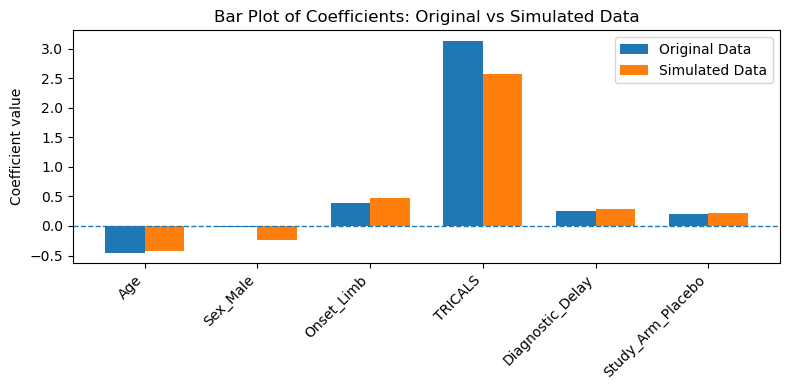

In [106]:
x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["Estimate_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["Estimate_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()


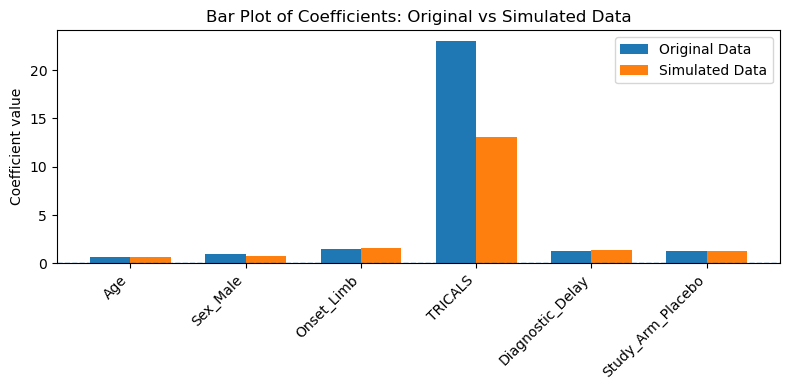

In [107]:
coefs1 = coefs[['Variable', 'HR_real', 'HR_simulated']]
coefs1

x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["HR_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["HR_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()

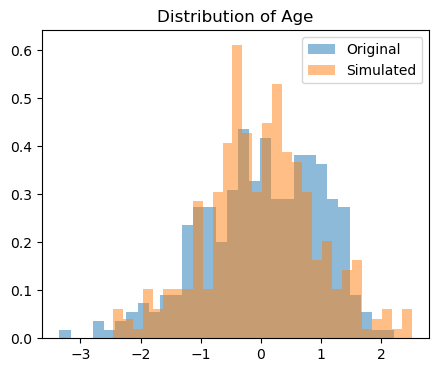

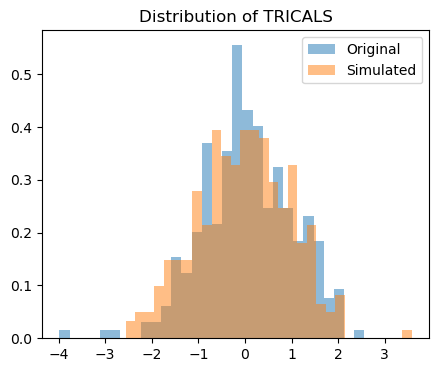

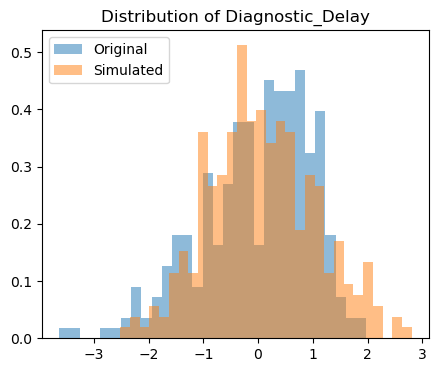

In [109]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(train_df[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_df[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

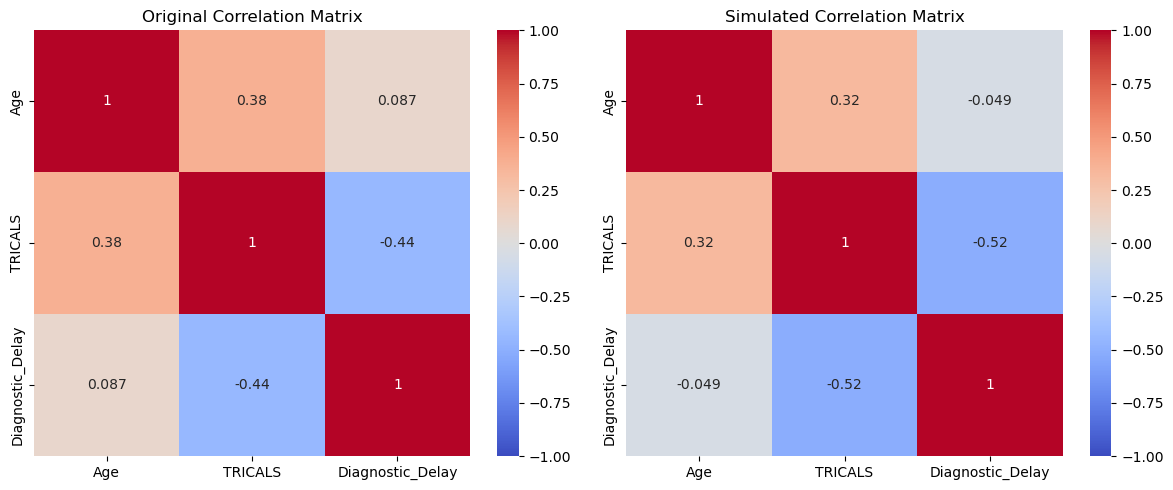

In [110]:
cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(train_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()

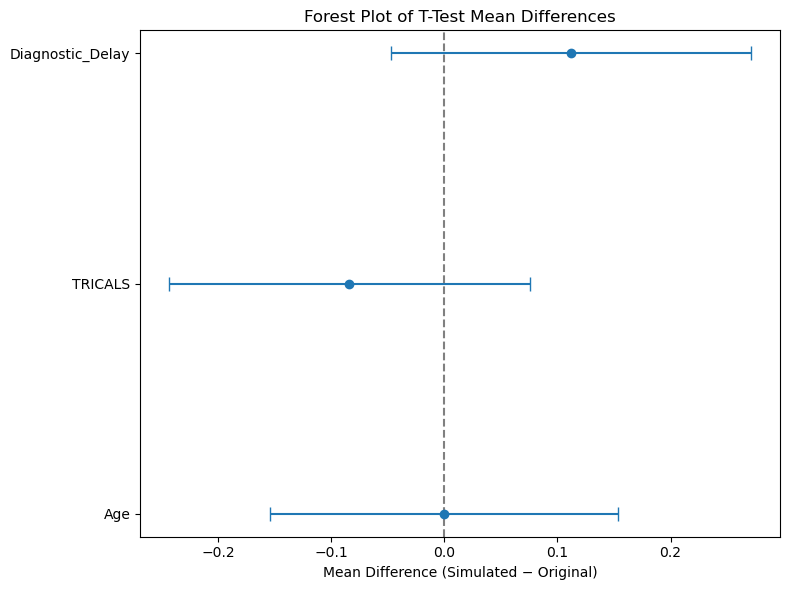

In [111]:
from scipy.stats import ttest_ind

cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

results = []

for col in cols:
    original = train_df[col].dropna()
    simulated = sim_df[col].dropna()

    # Welch t-test
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)

    # Mean difference
    mean_diff = simulated.mean() - original.mean()

    # Standard errors for CI (Welch)
    se = np.sqrt(original.var()/len(original) + simulated.var()/len(simulated))

    # 95% CI
    ci_low = mean_diff - 1.96 * se
    ci_high = mean_diff + 1.96 * se

    results.append([col, mean_diff, ci_low, ci_high, p_val])

df_plot = pd.DataFrame(results, columns=["Variable", "MeanDiff", "CI_low", "CI_high", "p_value"])


# --------- Forest Plot ---------
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    df_plot["MeanDiff"], 
    y_pos, 
    xerr=[df_plot["MeanDiff"] - df_plot["CI_low"], df_plot["CI_high"] - df_plot["MeanDiff"]],
    fmt='o', 
    capsize=5
)

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Mean Difference (Simulated − Original)")
plt.title("Forest Plot of T-Test Mean Differences")

plt.tight_layout()
plt.show()

In [ ]:
# remove the interaction term from the model